# Fractal Image Pipeline

This tutorial demonstrates **computed tables** by building an image processing pipeline for Julia fractals.

You'll learn:
- **Manual tables**: Parameters you define (experimental configurations)
- **Lookup tables**: Fixed reference data (processing methods)
- **Computed tables**: Automatically generated results via `populate()`
- **Many-to-many pipelines**: Processing every combination of inputs × methods

In [1]:
import datajoint as dj
import numpy as np
from matplotlib import pyplot as plt

schema = dj.Schema('tutorial_fractal')

[2026-01-11 18:57:40,023][INFO]: DataJoint 2.0.0a16 connected to root@127.0.0.1:3306


## Julia Set Generator

Julia sets are fractals generated by iterating $f(z) = z^2 + c$ for each point in the complex plane. Points that don't escape to infinity form intricate patterns.

In [2]:
def julia(c, size=256, center=(0.0, 0.0), zoom=1.0, iters=256):
    """Generate a Julia set image."""
    x, y = np.meshgrid(
        np.linspace(-1, 1, size) / zoom + center[0],
        np.linspace(-1, 1, size) / zoom + center[1]
    )
    z = x + 1j * y
    img = np.zeros(z.shape)
    mask = np.ones(z.shape, dtype=bool)
    for _ in range(iters):
        z[mask] = z[mask] ** 2 + c
        mask = np.abs(z) < 2
        img += mask
    return img

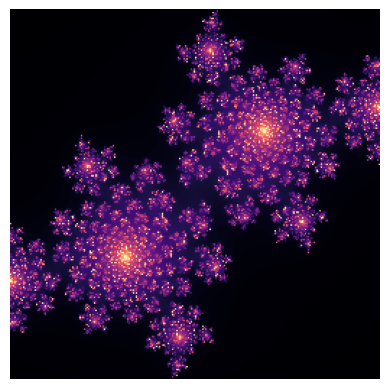

In [3]:
# Example fractal
plt.imshow(julia(-0.4 + 0.6j), cmap='magma')
plt.axis('off');

## Pipeline Architecture

We'll build a pipeline with four tables:

- **JuliaSpec** (Manual): Parameters we define for fractal generation
- **JuliaImage** (Computed): Generated from specs
- **DenoiseMethod** (Lookup): Fixed set of denoising algorithms
- **Denoised** (Computed): Each image × each method

After defining all tables, we'll visualize the schema with `dj.Diagram(schema)`.

In [4]:
@schema
class JuliaSpec(dj.Manual):
    """Parameters for generating Julia fractals."""
    definition = """
    spec_id : uint8
    ---
    c_real : float64          # Real part of c
    c_imag : float64          # Imaginary part of c  
    noise_level = 50 : float64
    """

In [5]:
@schema
class JuliaImage(dj.Computed):
    """Generated fractal images with noise."""
    definition = """
    -> JuliaSpec
    ---
    image : <blob>            # Generated fractal image
    """
    
    def make(self, key):
        spec = (JuliaSpec & key).fetch1()
        img = julia(spec['c_real'] + 1j * spec['c_imag'])
        img += np.random.randn(*img.shape) * spec['noise_level']
        self.insert1({**key, 'image': img.astype(np.float32)})

In [6]:
from skimage import filters, restoration
from skimage.morphology import disk

@schema
class DenoiseMethod(dj.Lookup):
    """Image denoising algorithms."""
    definition = """
    method_id : uint8
    ---
    method_name : varchar(20)
    params : <blob>
    """
    contents = [
        [0, 'gaussian', {'sigma': 1.8}],
        [1, 'median', {'radius': 3}],
        [2, 'tv', {'weight': 20.0}],
    ]

In [7]:
@schema
class Denoised(dj.Computed):
    """Denoised images: each image × each method."""
    definition = """
    -> JuliaImage
    -> DenoiseMethod
    ---
    denoised : <blob>
    """
    
    def make(self, key):
        img = (JuliaImage & key).fetch1('image')
        method, params = (DenoiseMethod & key).fetch1('method_name', 'params')
        
        if method == 'gaussian':
            result = filters.gaussian(img, **params)
        elif method == 'median':
            result = filters.median(img, disk(params['radius']))
        elif method == 'tv':
            result = restoration.denoise_tv_chambolle(img, **params)
        else:
            raise ValueError(f"Unknown method: {method}")
            
        self.insert1({**key, 'denoised': result.astype(np.float32)})

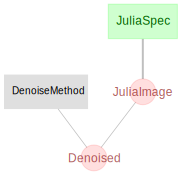

In [8]:
dj.Diagram(schema)

## Running the Pipeline

1. Insert specs into Manual table
2. Call `populate()` on Computed tables

In [9]:
# Define fractal parameters
JuliaSpec.insert([
    {'spec_id': 0, 'c_real': -0.4, 'c_imag': 0.6},
    {'spec_id': 1, 'c_real': -0.74543, 'c_imag': 0.11301},
    {'spec_id': 2, 'c_real': -0.1, 'c_imag': 0.651},
    {'spec_id': 3, 'c_real': -0.835, 'c_imag': -0.2321},
])
JuliaSpec()

spec_id,c_real Real part of c,c_imag Imaginary part of c,noise_level
0,-0.4,0.6,50.0
1,-0.74543,0.11301,50.0
2,-0.1,0.651,50.0
3,-0.835,-0.2321,50.0


In [10]:
# Generate all fractal images
JuliaImage.populate(display_progress=True)

JuliaImage:   0%|          | 0/4 [00:00<?, ?it/s]

JuliaImage:  25%|██▌       | 1/4 [00:00<00:00,  8.10it/s]

JuliaImage:  50%|█████     | 2/4 [00:00<00:00,  8.01it/s]

JuliaImage:  75%|███████▌  | 3/4 [00:00<00:00,  8.30it/s]

JuliaImage: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

{'success_count': 4, 'error_list': []}

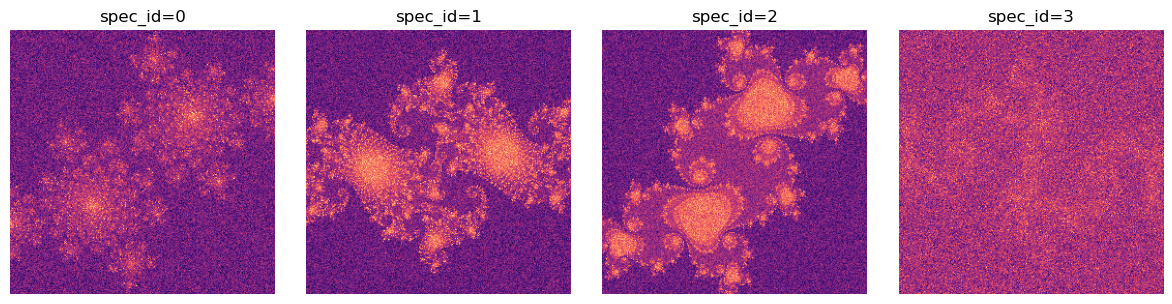

In [11]:
# View generated images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, row in zip(axes, JuliaImage()):
    ax.imshow(row['image'], cmap='magma')
    ax.set_title(f"spec_id={row['spec_id']}")
    ax.axis('off')
plt.tight_layout()

In [12]:
# Apply all denoising methods to all images
Denoised.populate(display_progress=True)

Denoised:   0%|          | 0/12 [00:00<?, ?it/s]

Denoised:  17%|█▋        | 2/12 [00:00<00:00, 18.56it/s]

Denoised:  42%|████▏     | 5/12 [00:00<00:00, 21.16it/s]

Denoised:  67%|██████▋   | 8/12 [00:00<00:00, 22.67it/s]

Denoised:  92%|█████████▏| 11/12 [00:00<00:00, 23.26it/s]

Denoised: 100%|██████████| 12/12 [00:00<00:00, 22.95it/s]

{'success_count': 12, 'error_list': []}

In [13]:
# 4 images × 3 methods = 12 results
print(f"JuliaImage: {len(JuliaImage())} rows")
print(f"DenoiseMethod: {len(DenoiseMethod())} rows")
print(f"Denoised: {len(Denoised())} rows")

JuliaImage: 4 rows
DenoiseMethod: 3 rows
Denoised: 12 rows


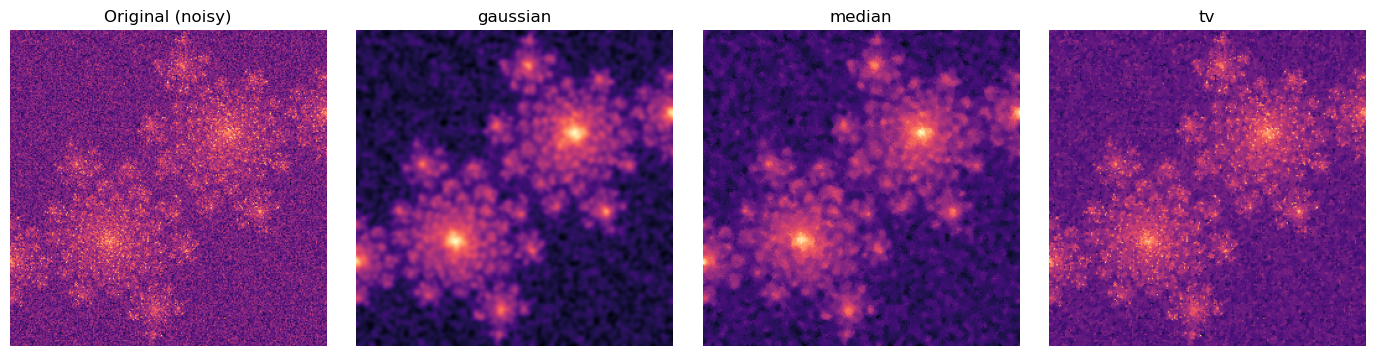

In [14]:
# Compare denoising methods on one image
spec_id = 0
original = (JuliaImage & {'spec_id': spec_id}).fetch1('image')

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
axes[0].imshow(original, cmap='magma')
axes[0].set_title('Original (noisy)')

for ax, method_id in zip(axes[1:], [0, 1, 2]):
    result = (Denoised & {'spec_id': spec_id, 'method_id': method_id}).fetch1('denoised')
    method_name = (DenoiseMethod & {'method_id': method_id}).fetch1('method_name')
    ax.imshow(result, cmap='magma')
    ax.set_title(method_name)

for ax in axes:
    ax.axis('off')
plt.tight_layout()

## Key Points

| Table Type | Populated By | Use For |
|------------|-------------|--------|
| **Manual** | `insert()` | Experimental parameters, user inputs |
| **Lookup** | `contents` attribute | Fixed reference data, method catalogs |
| **Computed** | `populate()` | Derived results, processed outputs |

The pipeline automatically:
- Tracks dependencies (can't process an image that doesn't exist)
- Skips already-computed results (idempotent)
- Computes all combinations when multiple tables converge

In [15]:
# Add a new spec — populate only computes what's missing
JuliaSpec.insert1({'spec_id': 4, 'c_real': -0.7, 'c_imag': 0.27})

JuliaImage.populate(display_progress=True)  # Only spec_id=4
Denoised.populate(display_progress=True)    # Only spec_id=4 × 3 methods

JuliaImage:   0%|          | 0/1 [00:00<?, ?it/s]

JuliaImage: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

JuliaImage: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

Denoised:   0%|          | 0/3 [00:00<?, ?it/s]

Denoised: 100%|██████████| 3/3 [00:00<00:00, 23.14it/s]

Denoised: 100%|██████████| 3/3 [00:00<00:00, 23.05it/s]

{'success_count': 3, 'error_list': []}

In [16]:
# Cleanup
schema.drop(prompt=False)